# Prediction of porosity in basalts of the Serra Geral Group

- Joao Paulo G. R. Alves - 2024
- joao (dot) guilherme (dot) alves (at) usp (dot) br
- Institute of Energy and Environment - University of Sao Paulo
- This is the full research script, meaning some of the stuff her was not used in the final paper

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import PredictionErrorDisplay
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde, pearsonr
import scipy.stats as stats
import statsmodels.api as sm
import os
import shap
import warnings
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# Read data from Excel
df = pd.read_excel("rawdata_porosity.xlsx")
data = df[['vp', 'density', 'porosity']].copy()

In [3]:
data.head()

,vp,density,porosity
0,4.799273,2.573227,6.083408
1,4.316942,2.471437,7.667464
2,3.964627,2.447632,7.219076
3,4.182352,2.602406,5.566899
4,4.128584,2.526487,7.447569


In [4]:
data.columns = ['Vp', 'Density', 'Porosity']

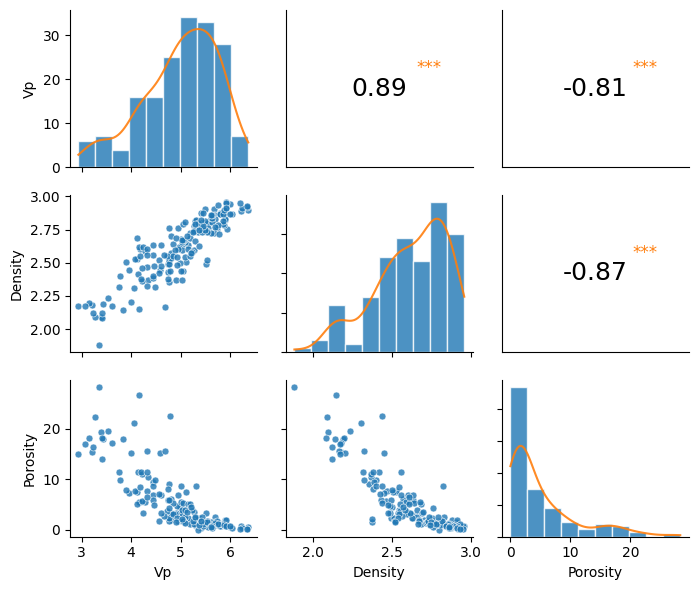

In [5]:
# corrdot function to plot correlation coefficient
def corrdot(x, y, ax=None, **kwargs):
    corr_r = x.corr(y, 'pearson')
    corr_text = round(corr_r, 2)
    if ax is not None:
        ax.annotate(corr_text, xy=(0.5, 0.5), xycoords="axes fraction",
                    ha='center', va='center', fontsize=18)

# corrfunc function to plot significance stars
def corrfunc(x, y, ax=None, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05: p_stars = '*'
    if p <= 0.01: p_stars = '**'
    if p <= 0.001: p_stars = '***'
    if ax is not None:
        ax.annotate(p_stars, xy=(0.7, 0.6), xycoords="axes fraction",
                    color='tab:orange', fontsize=12)

# Number of variables
n = len(data.columns)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(7, 6))

# Plot each pair of variables
for i in range(n):
    for j in range(n):
        ax = axs[i, j]
        if i == j:  # Diagonal plot with histogram and KDE
             # Histogram without density normalization
            counts, bins, patches = axs[i, j].hist(data[data.columns[i]], bins=10, color='tab:blue', alpha = 0.8, edgecolor='white')
            if j == 0:
                axs[i, j].xaxis.set_ticklabels([])
            elif j == n-1:
                axs[i, j].yaxis.set_ticklabels([])
            else:
                axs[i, j].xaxis.set_ticklabels([])
                axs[i, j].yaxis.set_ticklabels([])
            # KDE
            kde = gaussian_kde(data[data.columns[i]])
            x_range = np.linspace(bins.min(), bins.max(), 100)

            # Scale KDE by the count to match histogram scale
            kde_values = kde(x_range) * sum(counts) * np.diff(bins)[0]

            axs[i, j].plot(x_range, kde_values, color='tab:orange', alpha = 0.9)
            
        elif j > i:
            corrdot(data[data.columns[i]], data[data.columns[j]], ax=ax)
            corrfunc(data[data.columns[i]], data[data.columns[j]], ax=ax)
            axs[i, j].set_facecolor('white')
            for spine in axs[i, j].spines.values():
                spine.set_visible(True)
                spine.set_color('black')
            axs[i, j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
        else:
            axs[i, j].scatter(data[data.columns[j]], data[data.columns[i]], color='tab:blue', 
                              edgecolor='white', alpha=0.8, linewidth=0.5, s = 25)

        if i == n - 1:
            axs[i, j].set_xlabel(data.columns[j])
                
        if j == 0:
            axs[i, j].set_ylabel(data.columns[i])
                
        axs[i, j].spines[['right', 'top']].set_visible(False)

        if i == n-1 and j != 0:
            axs[i, j].yaxis.set_ticklabels([])

        if j == 0 and i != n-1:
            axs[i, j].xaxis.set_ticklabels([])

        if i != n-1 and j != 0:
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
        
plt.tight_layout()
plt.show()

In [6]:
data['Porosity'] = np.log10(data['Porosity'] - np.min(data['Porosity']) + 1)

In [7]:
# Removing extreme outliers using Z-score
def z_score(x):
    return (x - np.mean(x)) / np.std(x)

data = data[(np.abs(z_score(data['Vp'])) < 3) &
            (np.abs(z_score(data['Density'])) < 3) &
            (np.abs(z_score(data['Porosity'])) < 3)]

In [8]:
X = data.drop(columns = ['Porosity'])
y = data['Porosity']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
# Function to preprocess a dataframe
def preprocess_data(X, scaler=None):
    # Apply transformations
    X_transformed = X.copy()
    X_transformed['Vp'] = np.sqrt(np.max(X_transformed['Vp'] + 1) - X_transformed['Vp'])
        
    # Initialize MinMaxScaler for the main transformations if not provided
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(X_transformed)  # Fit scaler to the data
        X_scaled = scaler.transform(X_transformed)
    else:
        X_scaled = scaler.transform(X_transformed)  # Transform data using the existing scaler
    
    # Convert the scaled array back to a DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_transformed.columns, index=X_transformed.index)

    return X_scaled_df, scaler

In [11]:
X_train_transformed, scaler1 = preprocess_data(X_train)

In [12]:
X_test_transformed, _ = preprocess_data(X_test, scaler1)

In [13]:
models = [
    (GradientBoostingRegressor(random_state=42), {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (RandomForestRegressor(random_state=42), {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (SVR(), {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}),
    (LinearRegression(), {}),
    (Ridge(), {'alpha': [0.1, 1.0, 10.0], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']}),
    (ExtraTreeRegressor(random_state=42), {'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (BaggingRegressor(random_state=42), {'n_estimators': [10, 50, 100], 'max_samples': [0.5, 0.7, 1.0], 'max_features': [0.5, 0.7, 1.0]}),
    (XGBRegressor(random_state=42), {'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.01, 0.1, 0.2, 0.5, 0.7, 0.8], 'max_depth': [3, 5, 7, 9], 'subsample': [0.5, 0.55, 0.6, 0.65, 0.7, 0.8], 'min_child_weight': [1, 2, 4, 6, 8], 'gamma': [0, 0.1, 0.2, 0.3, 0.4]}),
    (Lasso(), {'alpha': [0.1, 1.0, 10.0], 'selection': ['cyclic', 'random']}),
    (DecisionTreeRegressor(random_state=42), {'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
]

In [14]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
results = []

In [16]:
for model, param_grid in models:
    model_name = model.__class__.__name__
    random_search = RandomizedSearchCV(estimator=model, 
                                       param_distributions=param_grid,  
                                       cv=cv_strategy,
                                       n_iter=10,
                                       verbose=2,
                                       random_state=42,  
                                       scoring='neg_mean_squared_error')
    
    random_search.fit(X_train_transformed, y_train)
    best_model = random_search.best_estimator_
    predictions = best_model.predict(X_test_transformed)
    
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    
    results.append([model_name, rmse, mae, r2])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estima

In [17]:
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R2'])

In [18]:
results_df.sort_values(by='RMSE', ascending=True, inplace=True)

In [19]:
print("Model Performance Comparison:")
print(results_df.to_string(index=False))

Model Performance Comparison:
                    Model     RMSE      MAE        R2
GradientBoostingRegressor 0.152588 0.110744  0.843739
                      SVR 0.165627 0.121654  0.815894
         LinearRegression 0.167556 0.122906  0.811579
                    Ridge 0.167627 0.123376  0.811420
    RandomForestRegressor 0.168439 0.120813  0.809588
         BaggingRegressor 0.172521 0.127028  0.800247
             XGBRegressor 0.173991 0.134161  0.796829
       ExtraTreeRegressor 0.197972 0.143790  0.736963
    DecisionTreeRegressor 0.210428 0.147274  0.702824
                    Lasso 0.386318 0.326536 -0.001607
